In [148]:
# Import all the appropriate libraries
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition, ensemble
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from itertools import product
from nltk import word_tokenize, FreqDist
from imblearn.over_sampling import SMOTE, ADASYN
nltk.download('punkt')
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcschneider/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install imblearn

In [9]:
# get json data from federal reserve 
r = requests.get('https://www.federalreserve.gov/json/ne-press.json')

In [10]:
# federal reserve json content
c = r.content

In [13]:
# clean up data using beautiful soup
json_file = BeautifulSoup(c)

In [14]:
# load data
json.loads(json_file.text[0:3568] + ']')

[{'d': '3/28/2019 4:30:00 PM',
  't': 'Federal Reserve Board releases document providing additional information on its stress testing program',
  'pt': 'Banking and Consumer Regulatory Policy',
  'l': '/newsevents/pressreleases/bcreg20190328a.htm'},
 {'d': '3/25/2019 2:00:00 PM',
  't': 'Federal and state financial regulatory agencies issue interagency statement on supervisory practices regarding financial institutions affected by flooding in the Midwest',
  'pt': 'Banking and Consumer Regulatory Policy',
  'l': '/newsevents/pressreleases/bcreg20190325a.htm'},
 {'d': '3/22/2019 5:00:00 PM',
  't': 'Federal Reserve Board announces approval of proposals by First Interstate Bank',
  'pt': 'Orders on Banking Applications',
  'l': '/newsevents/pressreleases/orders20190322a.htm'},
 {'d': '3/22/2019 12:00:00 PM',
  't': 'Federal Reserve System publishes annual financial statements',
  'pt': 'Other Announcements',
  'l': '/newsevents/pressreleases/other20190322a.htm'},
 {'d': '3/21/2019 12:00:

In [15]:
# split the data on "Federal Reserve issues FOMC statement"
our_list = json_file.text.split("Federal Reserve issues FOMC statement")

In [16]:
#Create links from the json file to access the statements from the FederalReserve website
links = []
for element in our_list[1:]:
    links.append('https://www.federalreserve.gov/newsevents' + element.split('newsevents')[1][0:36])

In [17]:
#filter out the html and sort out the article
documents=[]
for link in links:
    html_page= requests.get(link) 
    soup= BeautifulSoup(html_page.content, 'html.parser')
    article = soup.find("div",attrs={"class":"col-xs-12 col-sm-8 col-md-8"}).getText()
    documents.append(article)

In [18]:
#create an empty default column of data for our dataframe
listoftags=[]
for doc in documents:
    listoftags.append([doc,'dovish'])

In [19]:
#create a data frame
df= pd.DataFrame(listoftags)

In [20]:
#Export to Excel so that we can manually tag our articles
df.to_excel("FOMC.xlsx")

In [21]:
#Import newly tagged data
df=pd.read_excel("FOMC copy.xlsx")

In [23]:
#Dropped unnecessary column in place
df.drop(columns = 'Unnamed: 2', inplace= True)

KeyError: "['Unnamed: 2'] not found in axis"

In [25]:
#add column names
df.columns = ["Documents", "Category"]

In [26]:
#Defining function that cleans our data
def clean_data(data):
    cleaned_data = []
    for line in data:
        if not '[' in line and not ']' in line:
            for symbol in ",.?!''\n":
                line = line.replace(symbol, '').lower()
            cleaned_data.append(line)
    return "".join(cleaned_data)
data_without_brackets = clean_data(df.Documents[0])

In [27]:
#Apply function to column of data in pandas dataframe
df['Documents']= df['Documents'].apply(lambda x: clean_data(x))

In [29]:
#Instantiates a list of words to remove from our data, will be appended to at a later point
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [67]:
#This function returns a PARAGRAPH of words that have stopwords and numbers removed, MUST BE RERUN ... FOR NOW
def process_data(Documents):
    tokens = nltk.word_tokenize(Documents)
    stopwords_removed = ' '.join([token.lower() for token in tokens if token not in stopwords_list])
    pattern= r"[a-z]+"
    regex_tokens = re.findall(pattern, stopwords_removed)
    return ' '.join(regex_tokens)

In [31]:
# Creates a list from the column
document_words = df['Documents'].tolist()
category = df['Category'].tolist()

In [68]:
#Applies the function we created to the list of words and creates a new cleaned list of words
processed_data= list(map(process_data, document_words))

In [33]:
#Iterates through the new cleaned list to create a corpus
corpus= []
for i in processed_data:
    corpus.append(i)

In [34]:
# Create and empty column
df['Processed_Data'] = np.nan

In [35]:
# Pass the items into a fresh column in our dataframe
df['Processed_Data'] = df.apply(lambda x: corpus)

In [36]:
# Defining a function to tokenize the data that is now processed.
def tokenize(data):
    joined_data = ' '.join(data)
    tokenized_data = word_tokenize(data)
    
    return tokenized_data

tokenized_test_data = tokenize(df['Processed_Data'][0])

In [37]:
#Create a new column with tokenized data
df['Tokenized_Data']= df['Processed_Data'].apply(lambda x: tokenize(x))

## Word Tokenize and Frequency Distributions

In [41]:
#A frequency of all the words that are tokenized. Count of the words.
fdist = FreqDist()
for row in df['Tokenized_Data']:
    for word in row:
        fdist[word] += 1

In [43]:
#Creating a new dataframe
processed_words_df = pd.DataFrame(df['Tokenized_Data'])
categories_df = pd.DataFrame(category)
df_model= pd.concat([processed_words_df, categories_df], axis =1, sort= False)
df_model.columns= ['Statement_Words', 'Category']

In [46]:
# Creates a function to rejoin our tokenized data to create a raw document
def make_raw_doc(list_of_words):
    return ' '.join(list(list_of_words))

In [47]:
#Applies the function we created to create a new column
df_model['raw_document'] = df_model.Statement_Words.apply(lambda x: make_raw_doc(x))

## Count Vectorizing

In [49]:
#Instantiate a vectorizer to create a sparse matrix of our corpus
vectorizer = CountVectorizer()

In [50]:
#fits a model to our corpus
X = vectorizer.fit_transform(corpus)

## Addressing Endogeniety
> In econometrics, endogeneity broadly refers to situations in which an explanatory variable is correlated with the error term.
Remove terms the show up too frequently for example words and phrases like "Interest Rates are going up"

In [110]:
# sort our words by highest number of occurence
sorted_wordsbyappearance = sorted(vectorizer.vocabulary_.items(), key=lambda kv: kv[1], reverse=True)

In [111]:
# create a list of specific words we want to add to our stoplist
endolist = ['interest', 'rates', 'going', 'up', 'down', 'flat', 'constant','increasing','decreasing']

In [112]:
# if the occurance of a word is greater than 600 or the word is in our endolist, append it to our stopwords list
for i in sorted_wordsbyappearance:
    if i[1] > 600 or i[0] in endolist:
        stopwords_list.append(i[0])      

In [113]:
#This function returns a PARAGRAPH of words that have stopwords and numbers removed, MUST BE RERUN ... FOR NOW
def process_data(Documents):
    tokens = nltk.word_tokenize(Documents)
    stopwords_removed = ' '.join([token.lower() for token in tokens if token not in stopwords_list])
    pattern= r"[a-z]+"
    regex_tokens = re.findall(pattern, stopwords_removed)
    return ' '.join(regex_tokens)

In [114]:
# Creates a list from the column
document_words = df['Documents'].tolist()
category = df['Category'].tolist()

In [115]:
#Applies the function we created to the list of words and creates a new cleaned list of words
processed_data= list(map(process_data, document_words))

In [116]:
#Iterates through the new cleaned list to create a corpus
corpus= []
for i in processed_data:
    corpus.append(i)

In [117]:
# Create and empty column
df['Processed_Data'] = np.nan

In [118]:
# Pass the items into a fresh column in our dataframe
df['Processed_Data'] = df.apply(lambda x: corpus)

In [119]:
# Defining a function to tokenize the data that is now processed.
def tokenize(data):
    joined_data = ' '.join(data)
    tokenized_data = word_tokenize(data)
    
    return tokenized_data

tokenized_test_data = tokenize(df['Processed_Data'][0])

In [120]:
#Create a new column with tokenized data
df['Tokenized_Data']= df['Processed_Data'].apply(lambda x: tokenize(x))

## Word Tokenize and Frequency Distributions Second Pass

In [121]:
#A frequency of all the words that are tokenized. Count of the words.
fdist = FreqDist()
for row in df['Tokenized_Data']:
    for word in row:
        fdist[word] += 1

In [122]:
#Creating a new dataframe
processed_words_df = pd.DataFrame(df['Tokenized_Data'])
categories_df = pd.DataFrame(category)
df_model= pd.concat([processed_words_df, categories_df], axis =1, sort= False)
df_model.columns= ['Statement_Words', 'Category']

In [123]:
# Creates a function to rejoin our tokenized data to create a raw document
def make_raw_doc(list_of_words):
    return ' '.join(list(list_of_words))

In [124]:
#Applies the function we created to create a new column
df_model['raw_document'] = df_model.Statement_Words.apply(lambda x: make_raw_doc(x))

## Count Vectorizing Second Pass

In [125]:
#Instantiate a vectorizer to create a sparse matrix of our corpus
vectorizer = CountVectorizer()

In [126]:
#fits a model to our corpus
X = vectorizer.fit_transform(corpus)

# Sparse Matrix and Sparsity 

In [127]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurences: ', X.nnz)

Shape of Sparse Matrix:  (63, 615)
Amount of Non-Zero occurences:  8627


In [130]:
# showing our sparse matrix in a DataFrame
pd.DataFrame(X.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,605,606,607,608,609,610,611,612,613,614
0,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [131]:
# using our 'Shape of Sparse Matrix' and 'Amount of Non-Zero occurences' to create sparsity
sparsity = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('sparsity:', round(sparsity))

sparsity: 22


## Creating TD-IDF

In [140]:
#Creating TDidf on sparce matrix: Rare words have higher value and more frequent words have less value
tfidf_transformer = TfidfTransformer().fit(X)

In [141]:
#transforms sparse matrix in term frequencies
documents_tfidf = tfidf_transformer.transform(X)

## Test Train Split Data

In [145]:
#Split our data into train/test sets. Decided to use a 60/40 split because our data was not 
#large and we wanted to make sure get a reasonable distribution of our classes
X_train, X_test, y_train, y_test = model_selection.train_test_split(documents_tfidf, df_model['Category'], train_size = .6, random_state= 0)

In [147]:
#Shape of our Train and Test
print(X_train.shape , X_test.shape)

(37, 615) (26, 615)


## Handling Overfitting/Class Imbalance
>The majority of our data is tagged as "dovish", so we utilized imblearn's SMOTE function to help address our class imbalance.

In [151]:
#Resampled our X_train, y_train so we can have an equal representation of our classes
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

### New shape after including synthetic data

In [155]:
# X_resampled almost doubled the X_train
print(X_resampled.shape)

(62, 615)


# Multinomial Naive Bayes

In [156]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc

In [157]:
mb_model_resampled = MultinomialNB().fit(X_resampled, y_resampled)

In [158]:
y_score.shape

NameError: name 'y_score' is not defined

## Train MNB

AUC: 0.9516129032258064


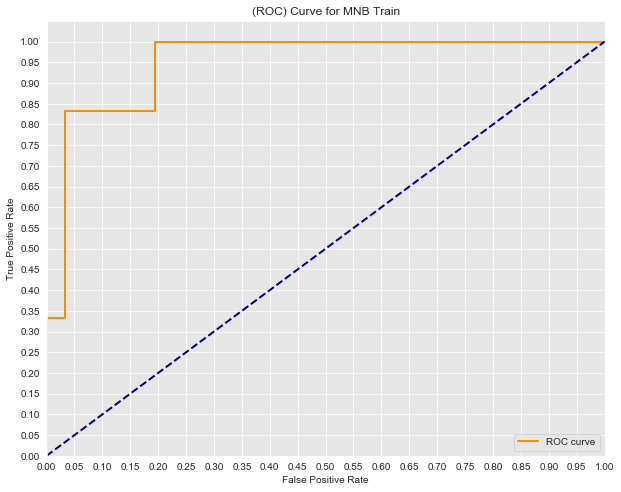

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

y_score= mb_model_resampled.predict_proba(X_train)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_train)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for MNB Train')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

## Test MNB

AUC: 0.9090909090909091


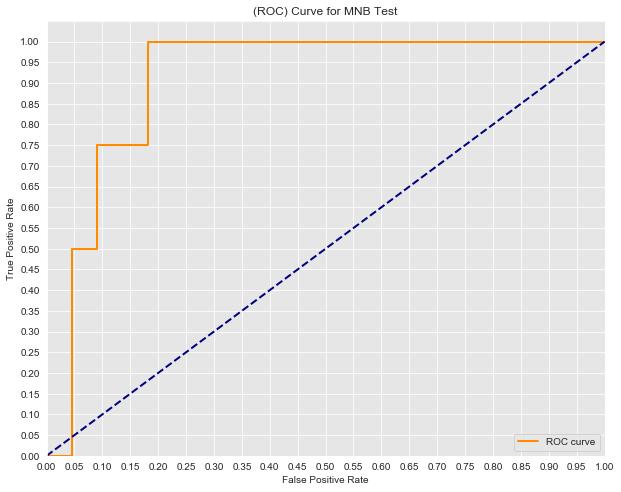

In [160]:
y_score= mb_model_resampled.predict_proba(X_test)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_test)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for MNB Test')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [161]:
mb_all_predictions_resampled = mb_model_resampled.predict(X_test)
print(mb_all_predictions_resampled)

['dovish' 'dovish' 'hawkish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'hawkish' 'hawkish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'hawkish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish']


In [162]:
print(classification_report(y_test, mb_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.82      0.90        22
     hawkish       0.50      1.00      0.67         4

   micro avg       0.85      0.85      0.85        26
   macro avg       0.75      0.91      0.78        26
weighted avg       0.92      0.85      0.86        26



In [163]:
mb_model_resampled.score(X_test, y_test)

0.8461538461538461

## Optimized Multinomial Niave Bayes with GridSearch

In [164]:
import numpy as np

In [165]:
# Create hyperparameter options

hyperparameters = {
    'alpha': (np.linspace(0,2,100)[1:]), 
    'fit_prior': (True, False)}

In [166]:
gs_mb= GridSearchCV(MultinomialNB(), hyperparameters)

NameError: name 'GridSearchCV' is not defined

In [167]:
best_model= gs_mb.fit(X_train, y_train)

NameError: name 'gs_mb' is not defined

In [168]:
print('Best Alpha:', best_model.best_estimator_.get_params()['alpha'])
print('Fit Prior:', best_model.best_estimator_.get_params()['fit_prior'])
print('Class Prior:', best_model.best_estimator_.get_params()['class_prior'])

NameError: name 'best_model' is not defined

AUC: 0.8977272727272727


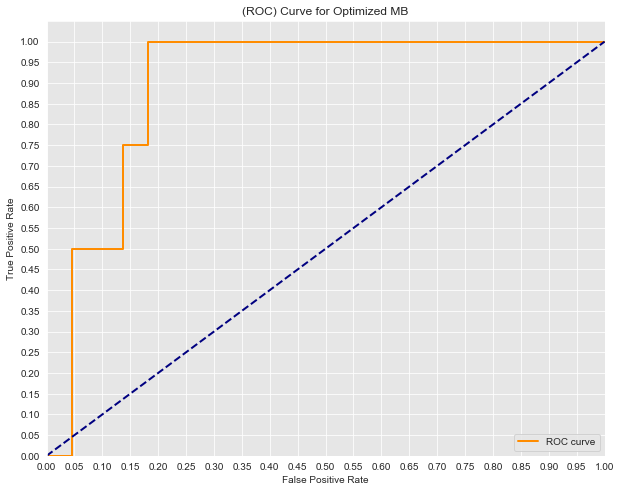

In [169]:
mb_model_resampled = MultinomialNB(alpha= .36, class_prior= [0.9, 0.1]).fit(X_resampled, y_resampled)

y_score= mb_model_resampled.predict_proba(X_test)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_test)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Optimized MB')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [170]:
lr_all_predictions_resampled = lr_model_resampled.predict(X_test)
print(lr_all_predictions_resampled)

NameError: name 'lr_model_resampled' is not defined

In [ ]:
cf1 = confusion_matrix(y_test, mb_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('MultiNomial Naive Bayes Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_resampled)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")
plt.grid("false")

plt.colorbar();

In [171]:
print(classification_report(y_test, mb_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.82      0.90        22
     hawkish       0.50      1.00      0.67         4

   micro avg       0.85      0.85      0.85        26
   macro avg       0.75      0.91      0.78        26
weighted avg       0.92      0.85      0.86        26



In [172]:
mb_model_resampled.score(X_test, y_test)

0.8076923076923077

>> ###  Hypertuning our Multinomial NB model increases did not change our AUC

# Random Forest

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
rf_model_resampled = RandomForestClassifier(min_samples_split= 4).fit(X_resampled, y_resampled)

## Random Forest Train

AUC: 1.0


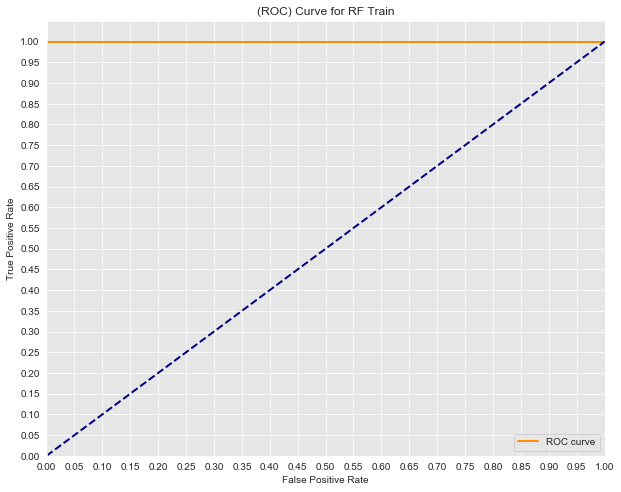

In [175]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

y_score= rf_model_resampled.predict_proba(X_train)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_train)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for RF Train')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

## Random Forest Test

AUC: 0.8068181818181819


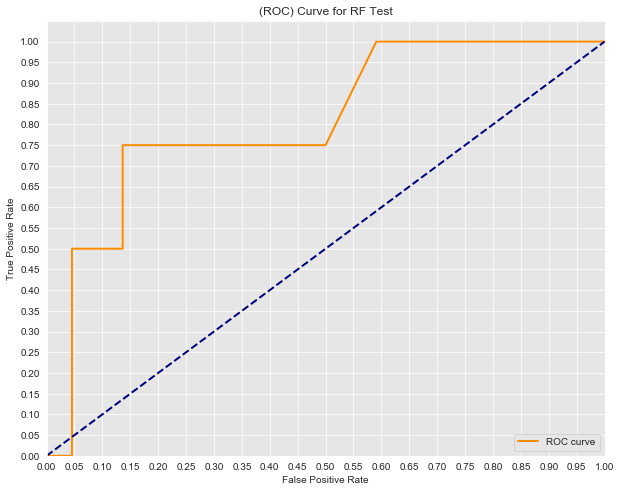

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

rf_model_resampled = RandomForestClassifier(min_samples_split= 4).fit(X_resampled, y_resampled)

y_score= rf_model_resampled.predict_proba(X_test)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_test)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for RF Test')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [177]:
rf_all_predictions_resampled = rf_model_resampled.predict(X_test)
print(rf_all_predictions_resampled)

['dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish']


In [178]:
rf_model_resampled.score(X_test, y_test)

0.8461538461538461

## Optimized Random Forest Model with Gridsearch

In [179]:
from sklearn.model_selection import GridSearchCV

In [180]:
# Create hyperparameter options
hyperparameters = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2, 5,10]
}

In [181]:
gs_rf= GridSearchCV(RandomForestClassifier(), hyperparameters)

In [182]:
best_model= gs_rf.fit(X_train, y_train)

In [183]:
print('Best N-Estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best Criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best Max Depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best Minimum Sample Split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best Min samples per leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])


Best N-Estimators: 10
Best Criterion: gini
Best Max Depth: None
Best Minimum Sample Split: 20
Best Min samples per leaf: 1


AUC: 0.8522727272727273


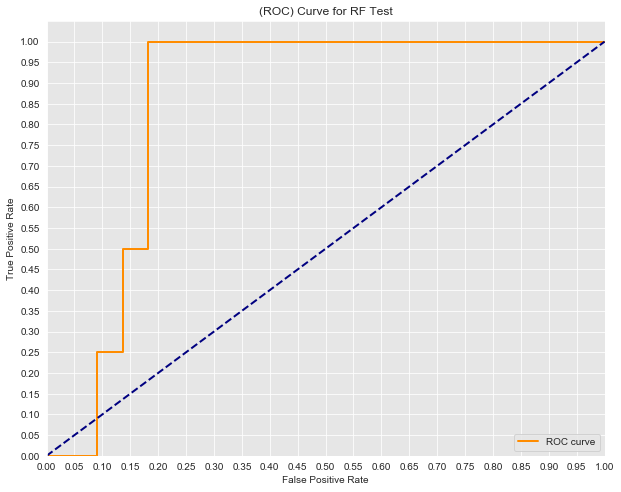

In [184]:
rf_model_resampled = RandomForestClassifier(n_estimators= 10, min_samples_leaf=5, min_samples_split= 10).fit(X_resampled, y_resampled)

y_score= rf_model_resampled.predict_proba(X_test)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_test)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for RF Test')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [185]:
rf_all_predictions_resampled = rf_model_resampled.predict(X_test)
print(rf_all_predictions_resampled)

['dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'hawkish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'hawkish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish']


In [187]:
print(classification_report(y_test, rf_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       0.83      0.91      0.87        22
     hawkish       0.00      0.00      0.00         4

   micro avg       0.77      0.77      0.77        26
   macro avg       0.42      0.45      0.43        26
weighted avg       0.71      0.77      0.74        26



/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


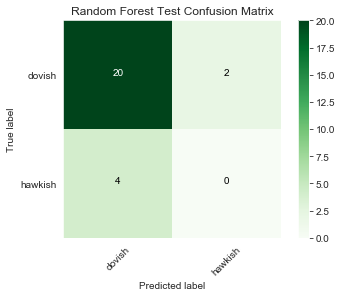

In [188]:
cf1 = confusion_matrix(y_test, rf_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('Random Forest Test Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_test)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")
plt.grid("false")

plt.colorbar();

>> ###  Hypertuning our random forest model increases our AUC by 7 percentage points

# Logistic Regression 

In [189]:
from sklearn.linear_model import LogisticRegression

In [190]:
lr_model_resampled = LogisticRegression().fit(X_train,y_train)

## Logistic Regression Train

AUC: 0.9731182795698925


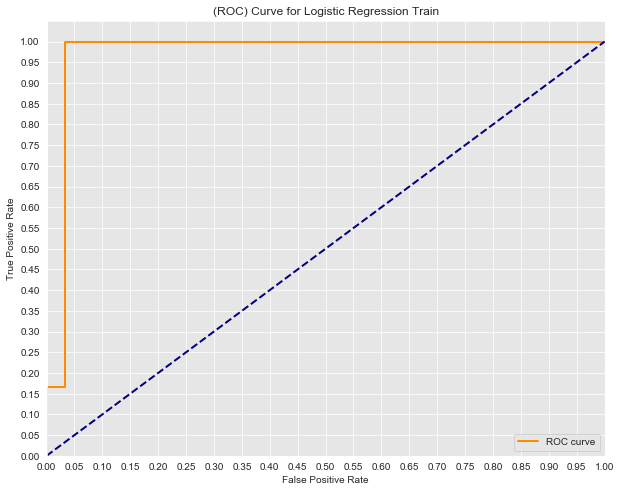

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

y_score= lr_model_resampled.predict_proba(X_train)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_train)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for Logistic Regression Train')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

## Logistic Regression Test

AUC: 0.875


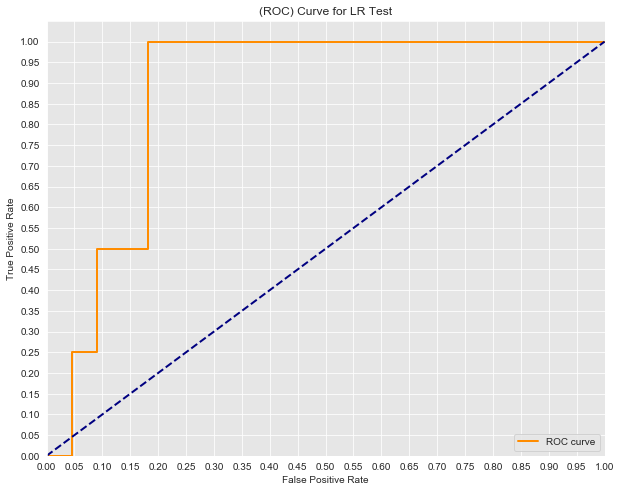

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing

y_score= lr_model_resampled.predict_proba(X_test)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_test)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for LR Test')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [193]:
lr_all_predictions_resampled = lr_model_resampled.predict(X_test)
print(lr_all_predictions_resampled)

['dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'dovish' 'dovish']


In [194]:
lr_model_resampled.score(X_test, y_test)

0.8461538461538461

## Optimized Logistic Regression with GridSearch

In [195]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [196]:
gs_lr= GridSearchCV(linear_model.LogisticRegression(), hyperparameters)

In [197]:
best_model= gs_lr.fit(X_train, y_train)

In [198]:
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])


Best C: 1.0
Best Penalty: l1


AUC: 0.8863636363636364


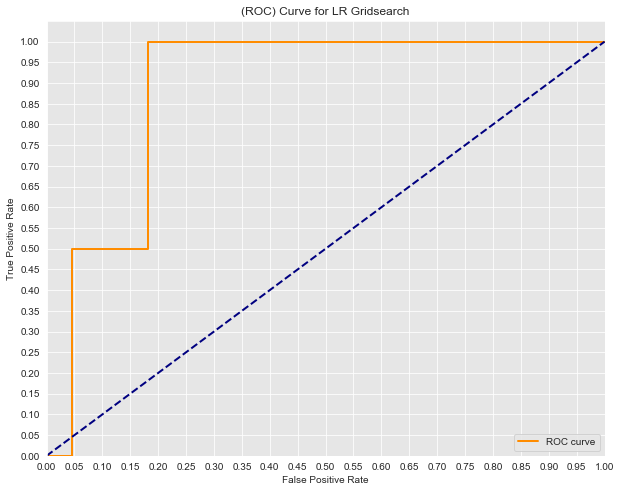

In [199]:
lr_model_resampled = linear_model.LogisticRegression(penalty= 'l1').fit(X_resampled, y_resampled)

y_score= lr_model_resampled.predict_proba(X_test)

lb= preprocessing.LabelBinarizer()
binary = lb.fit_transform(y_test)


fpr, tpr, thresholds = roc_curve(binary, y_score[:,1])
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(ROC) Curve for LR Gridsearch')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [200]:
lr_all_predictions_resampled = lr_model_resampled.predict(X_test)
print(lr_all_predictions_resampled)

['dovish' 'dovish' 'hawkish' 'dovish' 'dovish' 'dovish' 'dovish' 'dovish'
 'hawkish' 'hawkish' 'dovish' 'hawkish' 'hawkish' 'hawkish' 'dovish'
 'dovish' 'dovish' 'dovish' 'dovish' 'hawkish' 'hawkish' 'dovish' 'dovish'
 'dovish' 'dovish' 'dovish']


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


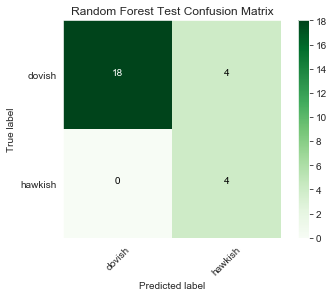

In [201]:
cf1 = confusion_matrix(y_test, lr_all_predictions_resampled)
plt.imshow(cf1, cmap=plt.cm.Greens)

plt.title('Random Forest Test Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

class_names = set(y_test)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cf1.max() / 2.

for i, j in product(range(cf1.shape[0]), range(cf1.shape[1])):
    plt.text(j, i, cf1[i, j],
         horizontalalignment="center",
         color="white" if cf1[i, j] > thresh else "black")
plt.grid("false")
plt.colorbar();

In [202]:
print(classification_report(y_test, lr_all_predictions_resampled))

              precision    recall  f1-score   support

      dovish       1.00      0.82      0.90        22
     hawkish       0.50      1.00      0.67         4

   micro avg       0.85      0.85      0.85        26
   macro avg       0.75      0.91      0.78        26
weighted avg       0.92      0.85      0.86        26



In [203]:
lr_model_resampled.score(X_test, y_test)

0.8461538461538461

>> ###  Hypertuning our random forest model increases our AUC by 4 percentage points

# Making Preditions with Our Model
We will pass quotes from characters in Games of Thrones, to see if our model can predict if the character is Dovish or Hawkish.

In [204]:
game_of_thrones = {
    'tyrion_lannister': "My brother has his sword, King Robert has his warhammer and I have my mind...and a mind needs books as a sword needs a whetstone if it is to keep its edge. That's why I read so much Jon Snow.",
    'jon_snow': "The more you give a king, the more he wants. We are walking on a bridge of ice with an abyss on either side. Pleasing one king is difficult enough, pleasing two is hardly possible.",
    'daenerys_targaryen': "I am Daenerys Stormborn of House Targaryen, of the blood of Old Valyeria. I am the dragon's daughter, and I swear to you that those who would harm you will die screaming.",
    'joffrey_baratheon': "I am the king! I will punish you.",
    'lord_of_ice_and_the_wardrobe': "The Well of the High Castle: The War fits into the Lion's song, and shelter us human, and power. Peter was the destiny and literature is miserable. His parents are every turn, and his own transition, Borlú of the best efforts of the creature's hideousness."}

In [216]:
def predictions(model, document):
    if model == 'mb':
        X = vectorizer.transform([document])
        documents_tfidf = tfidf_transformer.transform(X)
        return mb_model_resampled.predict(documents_tfidf)[0]
    elif model == 'rf':
        X = vectorizer.transform([document])
        documents_tfidf = tfidf_transformer.transform(X)
        return rf_model_resampled.predict(documents_tfidf)[0]
    elif model == 'lr':
        X = vectorizer.transform([document])
        documents_tfidf = tfidf_transformer.transform(X)
        return lr_model_resampled.predict(documents_tfidf)[0]

In [217]:
def got_characters_predictions(model):
    for character, quote in game_of_thrones.items():
        if model== 'mb':
            print(f'{" ".join(character.title().split("_"))} is {predictions(model,quote).title()}')
        elif model == 'lr':
            print(f'{" ".join(character.title().split("_"))} is {predictions(model,quote).title()}')     
        elif model == 'rf':
            print(f'{" ".join(character.title().split("_"))} is {predictions(model,quote).title()}')
        else:
            print('This is not a recognizable model')

In [218]:
got_characters_predictions('mb')

Tyrion Lannister is Dovish
Jon Snow is Dovish
Daenerys Targaryen is Dovish
Joffrey Baratheon is Dovish
Lord Of Ice And The Wardrobe is Dovish
